In [1]:
import datasets
from datasets import Dataset, DatasetDict

from torchvision.transforms import ToTensor, Normalize, Compose, Resize

In [1]:
from client.client import FlowerClient

FlowerClient.generate_deployment_clients(10, [])

Dataset partitioning config: {'partitioning': 'dirichlet', 'alpha': 0.5, 'batch_sizes': [32, 128, 16, 16, 64, 64, 64, 16, 32, 32], 'name': 'cifar10'}
Files already downloaded and verified
Files already downloaded and verified


AttributeError: Can't pickle local object '_download_data.<locals>.<lambda>'

In [ ]:
NUM_CLIENTS = 100
NUM_LABELS = 10

DEPLOYMENT_DATASET = "cifar10"
DEPLOYMENT_DATA_SAVE_PATH = "rework/deployment_data"

In [ ]:
# load dataset
try:
    dataset = datasets.load_from_disk(DEPLOYMENT_DATA_SAVE_PATH, keep_in_memory=False)
    print("Dataset found and loaded.")
except FileNotFoundError:
    print("Dataset not found, downloading...")
    dataset = datasets.load_dataset(path=DEPLOYMENT_DATASET, keep_in_memory=False)
    dataset.save_to_disk(DEPLOYMENT_DATA_SAVE_PATH)

In [8]:
from noniid.dataset.cifar10_noniid import get_dataset_cifar10_extr_noniid

num_users_cifar = 100
nclass_cifar = 2
nsamples_cifar = 20
rate_unbalance_cifar = 0.5




train_dataset_cifar, test_dataset_cifar, user_groups_train_cifar, user_groups_test_cifar = get_dataset_cifar10_extr_noniid(num_users_cifar, nclass_cifar, nsamples_cifar, rate_unbalance_cifar)


Files already downloaded and verified
Files already downloaded and verified


In [9]:
for user, group in user_groups_train_cifar.items():
    print(f"User {user} has {len(group)} samples.")

User 0 has 30 samples.
User 1 has 30 samples.
User 2 has 30 samples.
User 3 has 30 samples.
User 4 has 30 samples.
User 5 has 30 samples.
User 6 has 30 samples.
User 7 has 30 samples.
User 8 has 30 samples.
User 9 has 30 samples.
User 10 has 30 samples.
User 11 has 30 samples.
User 12 has 30 samples.
User 13 has 30 samples.
User 14 has 30 samples.
User 15 has 30 samples.
User 16 has 30 samples.
User 17 has 30 samples.
User 18 has 30 samples.
User 19 has 30 samples.
User 20 has 30 samples.
User 21 has 30 samples.
User 22 has 30 samples.
User 23 has 30 samples.
User 24 has 30 samples.
User 25 has 30 samples.
User 26 has 30 samples.
User 27 has 30 samples.
User 28 has 30 samples.
User 29 has 30 samples.
User 30 has 30 samples.
User 31 has 30 samples.
User 32 has 30 samples.
User 33 has 30 samples.
User 34 has 30 samples.
User 35 has 30 samples.
User 36 has 30 samples.
User 37 has 30 samples.
User 38 has 30 samples.
User 39 has 30 samples.
User 40 has 30 samples.
User 41 has 30 samples.
Us

In [4]:
from data.noniid_load_dataset import load_datasets

train_datasets, test_datasets, valid_set = load_datasets({
    "partitioning": "dirichlet",
    "similarity": 0.01,
    "name": "cifar10",
    "alpha": 0.5,
    "batch_sizes": [32] * 100,
    "labels_per_client": 2,
}, 100, seed=1)

Dataset partitioning config: {'partitioning': 'dirichlet', 'similarity': 0.01, 'name': 'cifar10', 'alpha': 0.5, 'batch_sizes': [32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32], 'labels_per_client': 2}
Files already downloaded and verified
Files already downloaded and verified


In [19]:
datapoints_per_client = [len(train_dl.dataset) + len(test_dl.dataset) for train_dl, test_dl in zip(train_datasets, test_datasets)]
# datapoints_per_client.sort()
print(datapoints_per_client)
print()
labels_per_client = [len(set([example[1] for example in train_dl.dataset]) | set([example[1] for example in test_dl.dataset])) for train_dl, test_dl in zip(train_datasets, test_datasets)]
# labels_per_client.sort()
print(labels_per_client)

[547, 520, 431, 669, 586, 309, 385, 784, 562, 566, 438, 544, 380, 784, 562, 516, 539, 407, 538, 409, 249, 556, 371, 307, 349, 585, 380, 501, 283, 551, 318, 205, 509, 570, 621, 218, 513, 619, 382, 947, 577, 1359, 506, 515, 562, 516, 528, 501, 565, 552, 563, 356, 529, 326, 513, 510, 147, 578, 598, 578, 537, 677, 535, 348, 390, 510, 396, 510, 218, 651, 327, 362, 745, 505, 414, 513, 480, 600, 302, 652, 444, 433, 274, 678, 532, 601, 685, 508, 322, 616, 285, 521, 563, 144, 333, 589, 700, 500, 468, 743]

[4, 8, 10, 9, 7, 10, 9, 6, 7, 7, 8, 4, 9, 5, 4, 3, 5, 9, 8, 8, 8, 6, 9, 10, 10, 8, 9, 3, 9, 10, 9, 7, 10, 3, 9, 10, 7, 10, 10, 9, 7, 9, 7, 4, 10, 9, 9, 8, 9, 6, 8, 9, 10, 8, 6, 6, 9, 8, 6, 2, 8, 8, 8, 10, 8, 9, 10, 6, 10, 8, 9, 8, 6, 8, 9, 8, 10, 7, 9, 8, 10, 9, 10, 7, 6, 10, 10, 9, 8, 10, 9, 9, 10, 10, 9, 9, 5, 10, 9, 10]


In [20]:
print(list(zip(datapoints_per_client, labels_per_client)))

[(547, 4), (520, 8), (431, 10), (669, 9), (586, 7), (309, 10), (385, 9), (784, 6), (562, 7), (566, 7), (438, 8), (544, 4), (380, 9), (784, 5), (562, 4), (516, 3), (539, 5), (407, 9), (538, 8), (409, 8), (249, 8), (556, 6), (371, 9), (307, 10), (349, 10), (585, 8), (380, 9), (501, 3), (283, 9), (551, 10), (318, 9), (205, 7), (509, 10), (570, 3), (621, 9), (218, 10), (513, 7), (619, 10), (382, 10), (947, 9), (577, 7), (1359, 9), (506, 7), (515, 4), (562, 10), (516, 9), (528, 9), (501, 8), (565, 9), (552, 6), (563, 8), (356, 9), (529, 10), (326, 8), (513, 6), (510, 6), (147, 9), (578, 8), (598, 6), (578, 2), (537, 8), (677, 8), (535, 8), (348, 10), (390, 8), (510, 9), (396, 10), (510, 6), (218, 10), (651, 8), (327, 9), (362, 8), (745, 6), (505, 8), (414, 9), (513, 8), (480, 10), (600, 7), (302, 9), (652, 8), (444, 10), (433, 9), (274, 10), (678, 7), (532, 6), (601, 10), (685, 10), (508, 9), (322, 8), (616, 10), (285, 9), (521, 9), (563, 10), (144, 10), (333, 9), (589, 9), (700, 5), (500, 

In [33]:
train_datasets2, test_datasets2, valid_set2 = load_datasets({
    "partitioning": "replicate",
    "similarity": 0.01,
    "name": "cifar10",
    "alpha": 1,
    "batch_size": 32,
    # "labels_per_client": 2,
    "datapoints_per_client": datapoints_per_client,
    # "datapoints_per_client": [500] * 100,
    # "labels_per_client": labels_per_client,
    "labels_per_client": [10] * 100,
}, 100, seed=2)

Dataset partitioning config: {'partitioning': 'replicate', 'similarity': 0.01, 'name': 'cifar10', 'alpha': 1, 'batch_size': 32, 'datapoints_per_client': [547, 520, 431, 669, 586, 309, 385, 784, 562, 566, 438, 544, 380, 784, 562, 516, 539, 407, 538, 409, 249, 556, 371, 307, 349, 585, 380, 501, 283, 551, 318, 205, 509, 570, 621, 218, 513, 619, 382, 947, 577, 1359, 506, 515, 562, 516, 528, 501, 565, 552, 563, 356, 529, 326, 513, 510, 147, 578, 598, 578, 537, 677, 535, 348, 390, 510, 396, 510, 218, 651, 327, 362, 745, 505, 414, 513, 480, 600, 302, 652, 444, 433, 274, 678, 532, 601, 685, 508, 322, 616, 285, 521, 563, 144, 333, 589, 700, 500, 468, 743], 'labels_per_client': [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10

In [35]:
s1 = [len(dl.dataset) for dl in train_datasets]
s1.sort()
s2 = [len(dl.dataset) for dl in train_datasets2]
s2.sort()
print(s1)
print(s2)
print(len(s1))
print(len(s2))

[130, 133, 185, 197, 197, 225, 247, 255, 257, 272, 277, 279, 287, 290, 294, 295, 300, 314, 315, 321, 326, 334, 342, 342, 344, 347, 351, 357, 367, 369, 373, 388, 390, 395, 400, 422, 432, 450, 451, 451, 455, 456, 458, 459, 459, 459, 459, 462, 462, 462, 464, 465, 465, 468, 469, 476, 477, 479, 482, 484, 485, 486, 490, 493, 496, 497, 501, 506, 506, 506, 507, 507, 509, 510, 513, 520, 521, 521, 527, 528, 531, 539, 540, 541, 555, 558, 559, 586, 587, 603, 610, 611, 617, 630, 669, 671, 706, 706, 853, 1224]
[130, 133, 185, 197, 197, 225, 247, 255, 257, 272, 277, 279, 287, 290, 294, 295, 297, 300, 314, 315, 321, 326, 334, 342, 342, 344, 347, 351, 357, 367, 369, 373, 388, 390, 395, 400, 422, 432, 450, 451, 451, 455, 456, 458, 459, 459, 459, 459, 462, 462, 462, 464, 465, 465, 468, 469, 476, 477, 479, 482, 484, 485, 486, 490, 493, 496, 497, 501, 506, 506, 506, 507, 507, 509, 510, 513, 520, 521, 521, 527, 528, 531, 539, 540, 541, 555, 558, 559, 586, 587, 603, 610, 611, 617, 630, 671, 706, 706, 853, 12

In [36]:
s1 = [len(set([example[1] for example in dl.dataset])) for dl in train_datasets]
s2 = [len(set([example[1] for example in dl.dataset])) for dl in train_datasets2]


In [37]:
s1.sort()
s2.sort()
print(s1)
print(s2)


[2, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


In [6]:
print(sum([len(dl.dataset) for dl in train_datasets]))
print(sum([len(dl.dataset) for dl in test_datasets]))
print(len(valid_set.dataset))

print(set([example[1] for example in train_datasets[11].dataset]))

for example in train_datasets[10].dataset:
    print(example[1])
    break

45053
4947
10000
{0, 1, 2, 5, 7}
0


(array([ 1.,  0.,  3.,  0.,  0.,  4.,  0.,  3.,  0.,  0., 13.,  0., 12.,
         0.,  0., 22.,  0., 22.,  0., 20.]),
 array([ 2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. ,
         6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ]),
 <BarContainer object of 20 artists>)

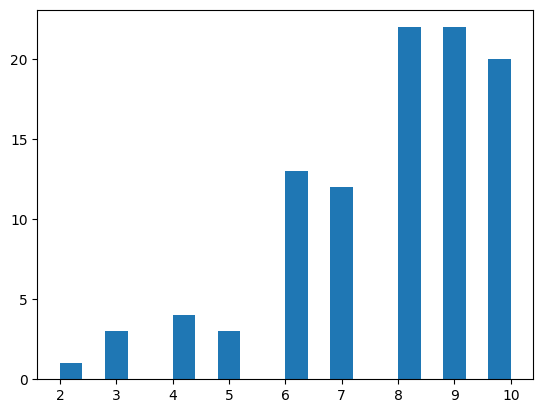

In [23]:
import matplotlib.pyplot as plt
plt.hist([len(set([example[1] for example in dl.dataset])) for dl in train_datasets2], bins=20)

(array([ 1.,  0.,  3.,  0.,  0.,  4.,  0.,  3.,  0.,  0.,  9.,  0.,  9.,
         0.,  0., 20.,  0., 30.,  0., 21.]),
 array([ 2. ,  2.4,  2.8,  3.2,  3.6,  4. ,  4.4,  4.8,  5.2,  5.6,  6. ,
         6.4,  6.8,  7.2,  7.6,  8. ,  8.4,  8.8,  9.2,  9.6, 10. ]),
 <BarContainer object of 20 artists>)

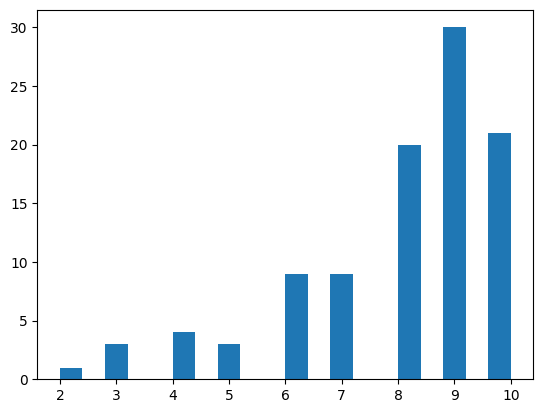

In [24]:
import matplotlib.pyplot as plt
plt.hist([len(set([example[1] for example in dl.dataset])) for dl in train_datasets], bins=20)

In [3]:
for dl in train_datasets:
    if len(set([example[1] for example in dl.dataset])) <= 7:
        print(len(dl.dataset))

KeyboardInterrupt: 

[451, 432, 471, 431, 411, 451, 536, 412, 432, 422, 451, 491, 471, 469, 410, 432, 525, 411, 432, 441, 432, 431, 469, 431, 431, 490, 546, 410, 410, 441, 431, 431, 489, 410, 421, 450, 525, 410, 410, 421, 430, 431, 469, 431, 469, 546, 546, 431, 410, 441, 440, 450, 479, 410, 410, 430, 525, 525, 430, 420, 430, 430, 479, 524, 409, 450, 585, 430, 410, 440, 430, 430, 469, 419, 419, 440, 545, 469, 420, 535, 450, 450, 468, 409, 408, 429, 545, 410, 410, 440, 429, 429, 468, 419, 429, 429, 545, 469, 420, 440]


(array([18.,  9., 27.,  8.,  8.,  0.,  9.,  2.,  2.,  3.,  0.,  0.,  0.,
         5.,  2.,  6.,  0.,  0.,  0.,  1.]),
 array([408.  , 416.85, 425.7 , 434.55, 443.4 , 452.25, 461.1 , 469.95,
        478.8 , 487.65, 496.5 , 505.35, 514.2 , 523.05, 531.9 , 540.75,
        549.6 , 558.45, 567.3 , 576.15, 585.  ]),
 <BarContainer object of 20 artists>)

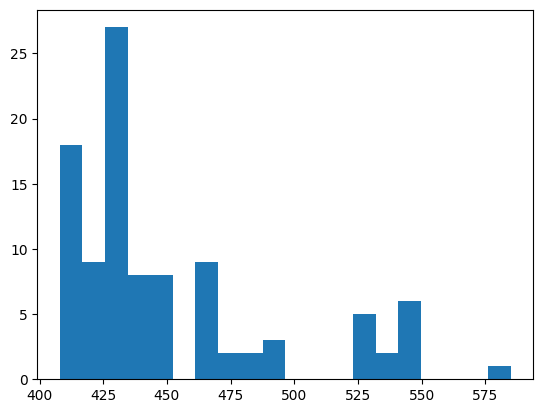

In [8]:
print([len(dl.dataset) for dl in train_datasets])
plt.hist([len(dl.dataset) for dl in train_datasets], bins=20)


In [20]:
from data.load_data import get_data_for_client
from torch.utils.data import DataLoader

client_data = get_data_for_client(0, 500)

In [13]:
dl = DataLoader(client_data, batch_size=32, shuffle=True)

In [19]:
print(len(set([example["label"] for example in dl.dataset["train"]])))

10


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from client.client import FlowerClient

client = FlowerClient(0, 32, 3, train_datasets[1], test_datasets[1])

In [9]:
from client.network import test

test(client.net, client.train_loader)

(2.2861200275584164, 0.0)